# Importing Essential Packages

In [0]:
import os, cv2 # to import directory of file
import zipfile
import pandas as pd #libraries to read
import numpy as np #for algebric function
import matplotlib.pyplot as plt # for visualization
import matplotlib.image as imgplt #for image visualization
import seaborn as sns #Seaborn for visualization

# Sklearn Libraries
from sklearn.model_selection import train_test_split #for test & train Split
from sklearn.metrics import confusion_matrix, accuracy_score # metrics
from sklearn.preprocessing import StandardScaler #for scaling to increase computing speed

#keras libraries
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPool2D, Dropout, Activation, AvgPool2D
from keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings("ignore")

# Read Doc

In [2]:
fdirl=[]
s_id = []
for dirname, _, filenames in os.walk('/content/drive/My Drive/Data science Project/chest-xrays-tuberculosis-from-india/images'):
    for filename in filenames:
        fdir = os.path.join(dirname, filename)
        s_idd = os.path.join(filename)
        fdirl.append(fdir)
        s_id.append(s_idd)
fdirl[:2]

['/content/drive/My Drive/Data science Project/chest-xrays-tuberculosis-from-india/images/TEST_nx1.jpg',
 '/content/drive/My Drive/Data science Project/chest-xrays-tuberculosis-from-india/images/TEST_nx18.jpg']

In [67]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# jaypee_metadata.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df = pd.read_csv('/content/drive/My Drive/Data science Project/chest-xrays-tuberculosis-from-india/jaypee_metadata.csv', delimiter=',', nrows = nRowsRead)
#df1.dataframeName = 'jaypee_metadata.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 155 rows and 2 columns


In [0]:
df[:5]

In [0]:
print(df["findings"].unique())
df[:2]

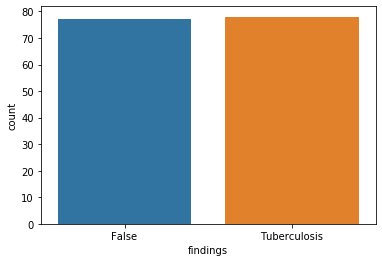

In [121]:
sns.countplot(df["findings"])
#data is equally distributed

# Assigning Lable Values

In [4]:
dft = df[df["findings"]=="Tuberculosis"]
dff = df[df["findings"]=="False"]
print(dft.shape)
print(dff.shape)

(78, 2)
(77, 2)


In [0]:
tt = dft["study_id"].to_list()
ff = dff["study_id"].to_list()

In [6]:
lable = []
for i in s_id:
  if i in tt:
     lable.append(1)
  if i in ff:
      lable.append(0)
lable = np.array(lable)
len(lable)

155

# Read Image

In [0]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (250, 250), interpolation=cv2.INTER_CUBIC)

In [8]:
train = np.array([read_image(i) for i in fdirl])
print("Train :",train.shape)

Train : (155, 250, 250, 3)


In [15]:
print("Count of TB pat  :",list(lable).count(1))
print("Count of False   :",list(lable).count(0))

Count of TB pat  : 78
Count of False   : 77


# Samle Image

Text(0.5, 1.0, '0')

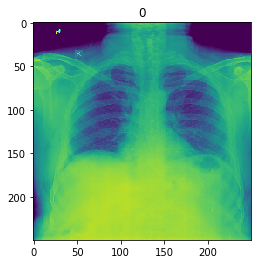

In [16]:
plt.imshow(train[7][:,:,0])
plt.title(lable[7])
#lable 0 --> No TB
#lable 1 --> TB

# Train & Test Split

In [71]:
x=train
y=lable
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=7)
#y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
int_sh = x_train.shape[1:]
print("Input shape :",int_sh)

(103, 250, 250, 3)
(52, 250, 250, 3)
(103, 1)
(52, 1)
Input shape : (250, 250, 3)


# CNN Model

In [0]:
def tbornot():
  model = Sequential()

  model.add(Conv2D(32,(3, 3), padding='same', input_shape=(250,250,3)))
  model.add(Activation("relu"))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(64,(3,3)))
  model.add(Activation("relu"))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(128,(3,3)))
  model.add(Activation("relu"))
  model.add(Conv2D(250,(3,3)))
  model.add(Activation("relu"))
  #model.add(Dropout(0.25))
  model.add(Conv2D(120,(3,3)))
  model.add(Activation("relu"))
  model.add(AvgPool2D(2,2))
  model.add(Conv2D(64,(3,3)))
  model.add(Activation("relu"))
  model.add(AvgPool2D(2,2))

  model.add(Conv2D(32,(2,2)))
  model.add(Activation("relu"))
  model.add(MaxPool2D(2,2))

  model.add(Flatten())
  model.add(Dense(32))
  model.add(Dropout(0.25))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))

  opt = keras.optimizers.Adam(0.001)
  model.compile(loss="binary_crossentropy",optimizer="Adam",metrics=["accuracy"])
  return model

In [0]:
model = tbornot()

# Learning Rate optimize

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=0.0001)

# Data Argumentation

In [0]:
datagen = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.2,
    rescale=1.0/255.0,
    rotation_range = 10)
datagen.fit(x_train)

# Fitting Model

In [158]:
mod2 = model.fit(datagen.flow(x_train,y_train,batch_size=30),
                validation_data=(x_train,y_train),epochs=100,callbacks=[reduce_lr])

Epoch 1/100
4/4 [==============================] - 4s 888ms/step - loss: 0.7404 - acc: 0.5171 - val_loss: 7.3549 - val_acc: 0.5437
Epoch 2/100
4/4 [==============================] - 1s 201ms/step - loss: 0.6850 - acc: 0.5605 - val_loss: 8.6677 - val_acc: 0.4563
Epoch 3/100
4/4 [==============================] - 1s 334ms/step - loss: 0.6951 - acc: 0.4225 - val_loss: 1.1648 - val_acc: 0.5728
Epoch 4/100
4/4 [==============================] - 1s 323ms/step - loss: 0.6905 - acc: 0.5779 - val_loss: 5.7996 - val_acc: 0.5437
Epoch 5/100
4/4 [==============================] - 1s 329ms/step - loss: 0.6937 - acc: 0.5257 - val_loss: 7.3043 - val_acc: 0.5437
Epoch 6/100
4/4 [==============================] - 1s 328ms/step - loss: 0.6894 - acc: 0.5431 - val_loss: 7.2658 - val_acc: 0.5437
Epoch 7/100
4/4 [==============================] - 1s 317ms/step - loss: 0.6918 - acc: 0.5257 - val_loss: 7.3241 - val_acc: 0.5437
Epoch 8/100
4/4 [==============================] - 1s 202ms/step - loss: 0.6850 - a

In [118]:
print(mod.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


# Report of Loss & Accuracy

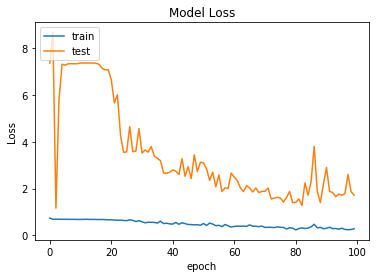

In [159]:
# summarize history for Loss
plt.plot(mod2.history["loss"])
plt.plot(mod2.history["val_loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

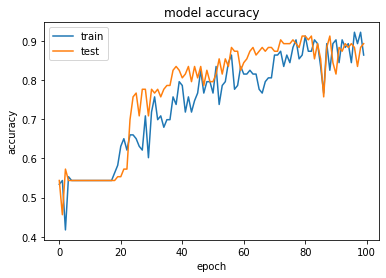

In [160]:
# summarize history for accuracy
plt.plot(mod2.history['acc'])
plt.plot(mod2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [161]:
y_pred = model.predict(x_test)
y_pred[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [162]:
print(accuracy_score(y_pred.round(),y_test))
cm = confusion_matrix(y_pred.round(),y_test,labels=[0,1])
cm

0.7115384615384616


array([[19, 13],
       [ 2, 18]])

# Confusion Matrix

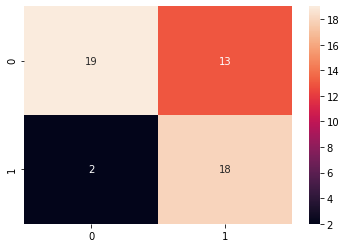

In [163]:
df_cm = pd.DataFrame(cm, index = [0,1],
                  columns = [0,1])
sns.heatmap(df_cm, annot=True)